In [63]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import scipy.special

In [36]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


In [68]:
data_flag = 'pneumoniamnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


In [41]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 4170669/4170669 [00:17<00:00, 244247.23it/s]

Using downloaded and verified file: C:\Users\Suket\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Suket\.medmnist\pneumoniamnist.npz


In [69]:

print(train_dataset)
print("===================")
print(test_dataset)



Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\Suket\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: C:\Users\Suket\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumon

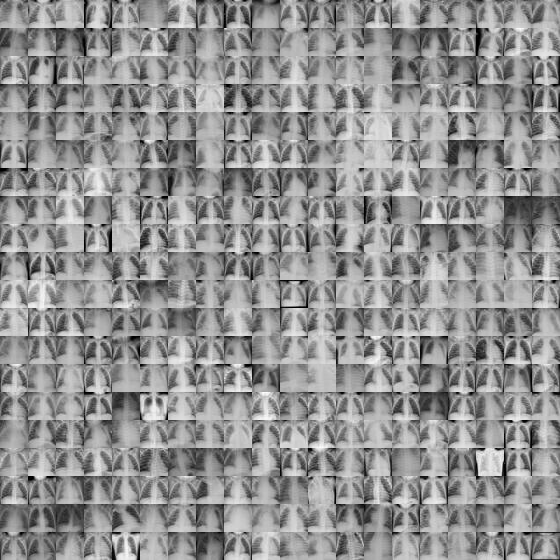

In [46]:


# visualization

train_dataset.montage(length=20)



In [70]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

100%|██████████| 37/37 [00:05<00:00,  6.36it/s]


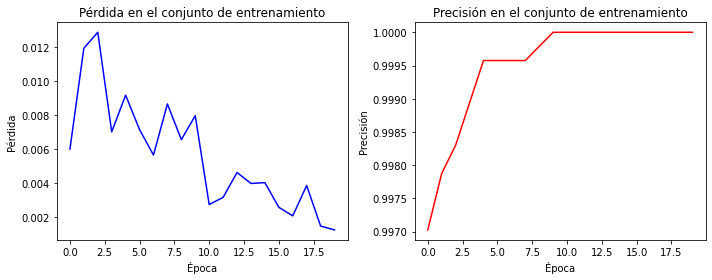

In [72]:
# train

# Crear listas para almacenar los valores de pérdida y precisión
train_loss_values = []
train_accuracy_values = []

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()
    
    train_accuracy = train_correct / train_total
    train_loss_values.append(loss.item())
    train_accuracy_values.append(train_accuracy)
    
# Graficar la pérdida y precisión cuando pase por todas las epocas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epoch + 1), train_loss_values, 'b-')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida en el conjunto de entrenamiento')
    
plt.subplot(1, 2, 2)
plt.plot(range(epoch + 1), train_accuracy_values, 'r-')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión en el conjunto de entrenamiento')
    
plt.tight_layout()
plt.show()

==> Evaluating ...
train  auc: 1.000  acc:1.000


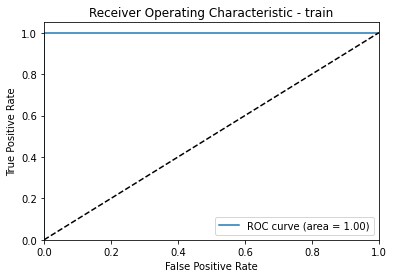

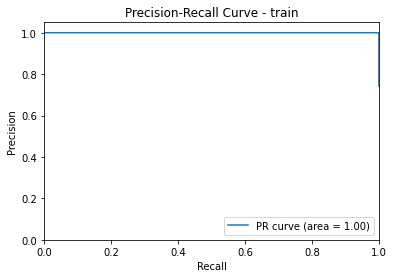

test  auc: 0.968  acc:0.880


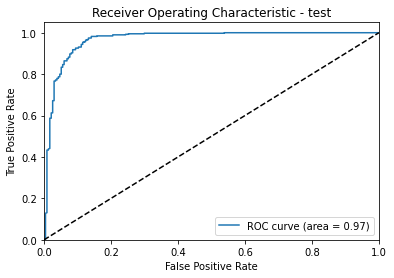

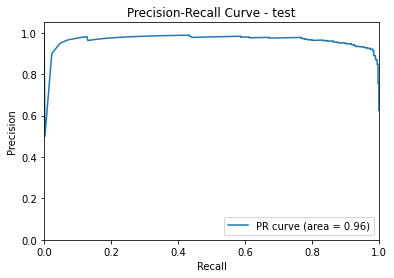

In [73]:
# evaluacion

def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - ' + title)
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall(y_true, y_score, title):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - ' + title)
    plt.legend(loc="lower right")
    plt.show()

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
            else:
                targets = targets.squeeze().long()
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        # Aplicar softmax solo si es necesario para otras métricas
        if task != 'multi-label, binary-class':
            y_score = scipy.special.softmax(y_score, axis=-1)

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        
        # Graficar la curva ROC y la curva PR
        plot_roc(y_true, y_score[:, 1], split)  # Utilizar solo la columna de la clase positiva
        plot_precision_recall(y_true, y_score[:, 1], split)  # Utilizar solo la columna de la clase positiva

        
print('==> Evaluating ...')
test('train')
test('test')